In [1]:
import os
import numpy as np 

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dat_dir = '/global/cscratch1/sd/chahah/provabgs/emulator/'
version = '0.1'

In [4]:
ibin = 0

_wave = np.load(os.path.join(dat_dir, 'wave.burst.npy'))
wave_bins = [(_wave < 3600), (_wave >= 3600) & (_wave < 5500), (_wave >= 5500) & (_wave < 7410), (_wave >= 7410)]
wave = _wave[wave_bins[ibin]]

In [5]:
flnspec = lambda ii: os.path.join(dat_dir, 'fsps.burst.v%s.lnspectrum.seed%i.w%i.npy' % (version, ii, ibin))

In [6]:
lnspec = np.empty((1000000, len(wave)))
for i in range(100): 
    lnspec[i*10000:(i+1)*10000,:] = np.load(flnspec(i))

In [7]:
lnspec_test = np.load(os.path.join(dat_dir, 'fsps.burst.v%s.lnspectrum.test.npy' % version))[:,wave_bins[ibin]]

Text(0, 0.5, '$\\log f_{\\rm SED}$')

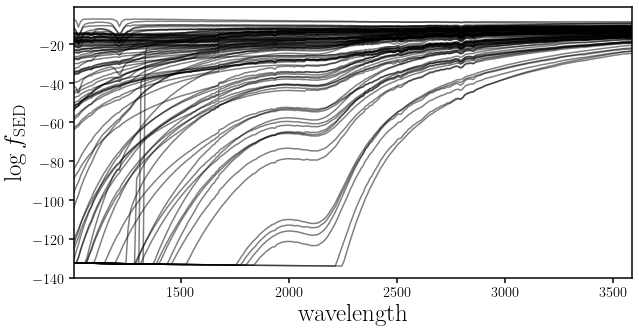

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for lns in lnspec[::10000]: 
    sub.plot(wave, lns, c='k', alpha=0.5)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel(r'$\log f_{\rm SED}$', fontsize=25)

Text(0, 0.5, '$f_{\\rm SED}$')

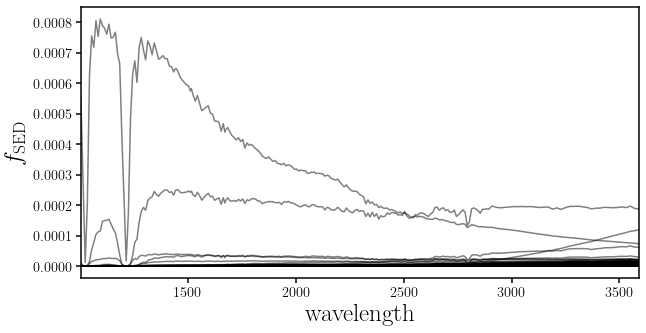

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for lns in lnspec[::10000]: 
    sub.plot(wave, np.exp(lns), c='k', alpha=0.5)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel(r'$f_{\rm SED}$', fontsize=25)

In [10]:
from sklearn.decomposition import PCA

In [11]:
lnpca = PCA(n_components=70)
lnpca.fit(lnspec)

PCA(copy=True, iterated_power='auto', n_components=70, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

(0.0, 70)

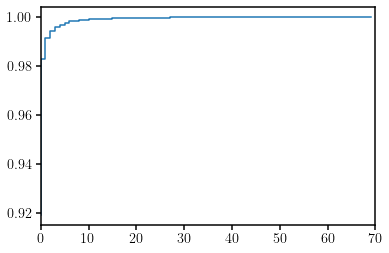

In [12]:
plt.step(range(len(lnpca.explained_variance_ratio_)), np.cumsum(lnpca.explained_variance_ratio_))
plt.xlim(0., len(lnpca.explained_variance_ratio_))

In [13]:
lnpca_test = lnpca.transform(lnspec_test)
lnspec_recon = lnpca.inverse_transform(lnpca_test)

(0.0, 0.0001)

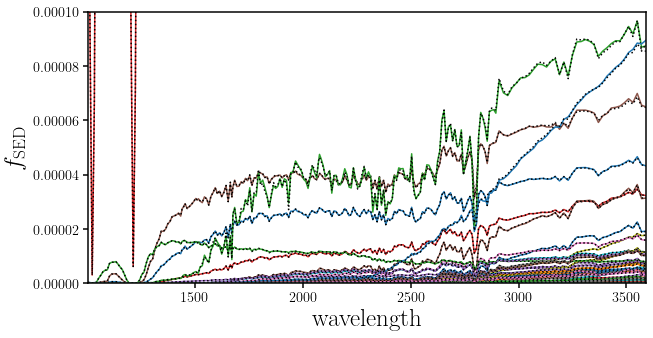

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i, lns_t, lns_r in zip(range(int(lnspec_test.shape[0]/1000)), lnspec_test[::1000], lnspec_recon[::1000]): 
    sub.plot(wave, np.exp(lns_t), c='C%i' % i) 
    sub.plot(wave, np.exp(lns_r), c='k', ls=':')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel(r'$f_{\rm SED}$', fontsize=25)
sub.set_ylim(0., 1e-4)

In [15]:
frac_dspec = 1. - np.exp(lnspec_recon.clip(-40, None) - lnspec_test.clip(-40, None))
frac_dspec_q = np.nanquantile(frac_dspec, [0.0005, 0.005, 0.025, 0.5, 0.975, 0.995, 0.9995], axis=0)

(-0.1, 0.1)

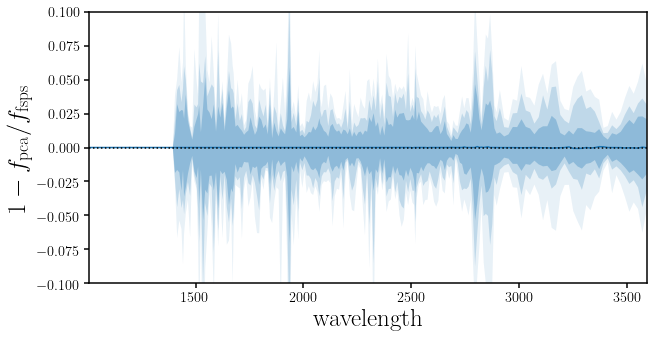

In [17]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.fill_between(wave, frac_dspec_q[0], frac_dspec_q[6], fc='C0', ec='none', alpha=0.1, label='99.9%')
sub.fill_between(wave, frac_dspec_q[1], frac_dspec_q[5], fc='C0', ec='none', alpha=0.2, label='99%')
sub.fill_between(wave, frac_dspec_q[2], frac_dspec_q[4], fc='C0', ec='none', alpha=0.3, label='95%')
sub.plot(wave, frac_dspec_q[3], c='C0', ls='-')
sub.plot(wave, np.zeros(len(wave)), c='k', ls=':')
#sub.plot(wave, 0.1*np.ones(len(wave)), c='k', ls=':')
#sub.plot(wave, -0.1*np.ones(len(wave)), c='k', ls=':')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel(r'$1 - f_{\rm pca}/f_{\rm fsps}$', fontsize=25)
sub.set_ylim(-0.1, 0.1)

(0.0, 1.0)

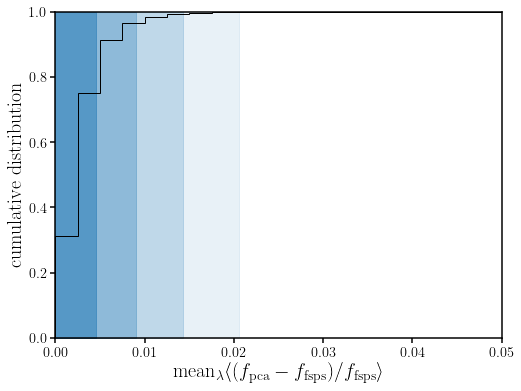

In [22]:
mean_frac_dspec = np.mean(np.abs(1. - np.exp(lnspec_recon.clip(-30, None) - lnspec_test.clip(-30, None))), axis=1)
quant = np.quantile(mean_frac_dspec, [0.68, 0.95, 0.99, 0.999])
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for q, a in zip(quant[::-1], [0.1, 0.2, 0.3, 0.5]):
    sub.fill_between([0., q], [0., 0.], [1., 1.], alpha=a, color='C0')
_ = sub.hist(mean_frac_dspec, bins=400, range=(0., 1.), density=True, histtype='step', cumulative=True, color='k')
sub.set_xlabel(r'${\rm mean}_\lambda \langle (f_{\rm pca}  - f_{\rm fsps}) / f_{\rm fsps} \rangle$', fontsize=20)
sub.set_xlim(0., 0.05)
sub.set_ylabel('cumulative distribution', fontsize=20)
sub.set_ylim(0., 1.)